![Practicum AI Logo image](https://github.com/PracticumAI/practicumai.github.io/blob/main/images/logo/PracticumAI_logo_250x50.png?raw=true) <img src='https://github.com/PracticumAI/deep_learning/blob/main/images/practicumai_deep_learning.png?raw=true' alt='Practicum AI: Deep Learning Foundations icon' align='right' width=50>
***

# Computer Vision Concepts Continued

Kevin now has a decent understanding of CNNs and how they work, but his model is still not performing as well as he would like. He's been reading up on some techniques to improve his model's performance and is excited to try them out. 

One particularly good article on this is topic is Ayush Thakur and Aritra Roy Gosthipaty's article [Simple Ways to Tackle Class Imbalance](https://wandb.ai/authors/class-imbalance/reports/Simple-Ways-to-Tackle-Class-Imbalance--VmlldzoxODA3NTk) (Thakur & Gosthipaty). Look through this article, and the explanations of the methods.


## [!!!INSERT IMAGE ABOUT CLASS IMBALANCE!!!]


## 1. Import the libraries we will use

In [9]:
import tensorflow as tf   # Import the TensorFlow library, which provides tools for deep learning.
import pandas as pd  # Import the pandas library, used for data manipulation and analysis.
from sklearn.model_selection import train_test_split
import datetime

# Used for data management
import requests
import os
import time
import tarfile

import matplotlib.pyplot as plt  # Import the matplotlib library for plotting and visualization.
# This line allows for the display of plots directly within the Jupyter notebook interface.
%matplotlib inline  
 
# Import Keras libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Import the ImageDataGenerator class from Keras module in TensorFlow.
from tensorflow.keras.models import Sequential  # Import the Sequential model: a linear stack of layers from Keras module in TensorFlow.
from tensorflow.keras.layers import Dense  # Import the Dense layer: a fully connected neural network layer from Keras module in TensorFlow.
from tensorflow.keras.layers import Flatten  # Import the Flatten layer: used to convert input data into a 1D array from Keras module in TensorFlow.
from tensorflow.keras.losses import SparseCategoricalCrossentropy  # Import the SparseCategoricalCrossentropy loss function from Keras module in TensorFlow.
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers 
from tensorflow.keras import losses
from sklearn.metrics import confusion_matrix 
import numpy as np 

from sklearn.utils import class_weight

# Import helper functions--most of these were in the cells of the DLF_03_bees_vs_wasps.ipynb notebook.
# We moved them out of the notebook to enhace readability. 
import helpers_01

# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## 2. Exploring the data

As before we'll use our helper function `helpers_01.manage_data` to make sure we have the data and set the `data_path`.

In the last notebook, Kevin noticed that his model had a big problem: it thought everything was wasps! Let's explore the data a bit and see if we can figure out why.

First let's make a histogram of the number of images in each class. That should give us a good idea of how balanced the dataset is.

In [3]:
# Chech for the data.
data_path = helpers_01.manage_data() 

Found data at /blue/practicum-ai/share/data/bee_vs_wasp.


Category wasp: 4,943 images, or 43.3% of total images.
Category bee: 3,184 images, or 27.9% of total images.
Category other_insect: 2,439 images, or 21.4% of total images.
Category other_noinsect: 856 images, or 7.5% of total images.
************************************


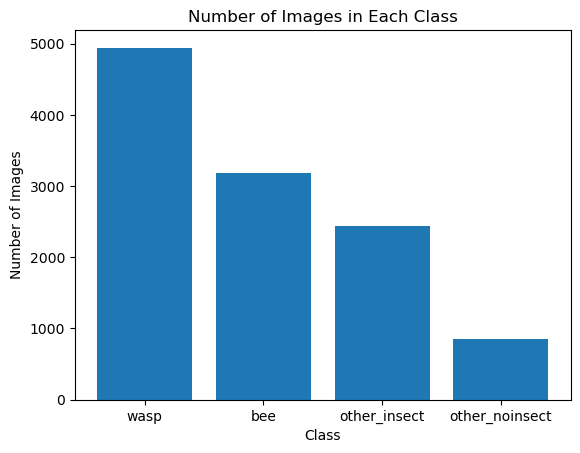

In [4]:
# Make a histogram of the number of images in each class
def make_hist_get_max(data_path):
    # Get the class names
    class_names = os.listdir(data_path)

    # Initialize an empty list to store the number of images in each class
    num_images = []

    # Loop through each class
    for class_name in class_names:
        # Get the list of images in the class
        images = os.listdir(os.path.join(data_path, class_name))
        # Append the number of images in the class to the list
        num_images.append(len(images))

    # Put the number of images in each class in descending order
    num_images, class_names = zip(*sorted(zip(num_images, class_names), reverse=True))

    total_images = sum(num_images)
    
    # Print the number of images in each class
    for i in range(len(class_names)):
        percentage = (num_images[i] / total_images) * 100
        print(f'Category {class_names[i]}: {num_images[i]:,} images, or {percentage:.1f}% of total images.')

    print("************************************")       
        
    # Create a histogram of the number of images in each class
    plt.bar(class_names, num_images)
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.title('Number of Images in Each Class')
    plt.show()

    return num_images

num_images = make_hist_get_max(data_path)

Yikes! That's a pretty big class imbalance--there are almost 5,000 wasp images and less than 1,000 other non-insect images. Large class imbalances tend to make models biased towards the majority class. This is likely why Kevin's model was predicting everything as wasps. Let's try to fix this!

Part of the issue with imballanced data is that the algorithm can do fairly well by never predicting the rare class(es).

As an example, let's imaging we are looking at a rare disease. If only 5% of the data are from the disease state, a model can be 95% accurate by never predicting disease. That 95% accuracy sounds good, but the model is not too helpful!

## 3. Class Weighting

The first method we will implement is adding class weighting. As Thakur & Gosthipaty write:
> One of the easiest ways to counter class imbalance is to use class weights wherein we give different weightage to different classes. The number of samples in the classes is considered while computing the class weights. We apply more significant weight to a minority class, which places more emphasis on that class. The classifier thus learns equally from both the classes. [Their example had only two classes]
>
> Class weights regularize the loss function. By misclassifying the minority class, a higher loss is incurred by the model since the minority class has a higher weight. This forces the model to learn representations for the minority class. This, however, comes at a price of slightly reduced performance for the majority class.

Note that they were dealing with two classes, here, we have four. Our code will handle datasets with different numbers of classes.

We'll start using a slightly modified version of the `load_display_data` function we used in the first notebook. It is now in the `helpers_01` module we imported. We will pass `show_pictures=False` to skip that.


In [59]:
X_train, X_valid, cls_counts = helpers_01.load_display_data(data_path, 
                batch_size=32, shape=(80,80,3), show_pictures=False,
                return_cls_counts=True)

***********************************************************************
Load data:
  - Loading the dataset from: /blue/practicum-ai/share/data/bee_vs_wasp.
  - Using a batch size of: 32.
  - Resizing input images to: (80, 80, 3).
  - Returning class counts for later use? True
***********************************************************************
Found 11422 files belonging to 4 classes.
Using 9138 files for training.
Found 11422 files belonging to 4 classes.
Using 2284 files for validation.

Getting number of images per class. This may take a bit...

For the Training set:
Category bee: 2552 images or 27.9% of total images.
Category other_insect: 1945 images or 21.3% of total images.
Category other_noinsect: 698 images or 7.6% of total images.
Category wasp: 3943 images or 43.1% of total images.


## 4. Make our model

This function creates the model we will use.

One hyperparameter to explore is the activation function, which is set when making the model. We start with a ReLU as the default, but you can try others. For simplicity, we will use the same activation function for all but the last layer of the model, but you could change them individually.

The last layer will almost always use a Softmax, which makes all the output values between 0 and 1 and sum to 1, transforming them into probabilities of the input belonging to each possible class.

In [60]:
def make_model(activation='relu', shape=(80,80,3), num_classes=4):
    '''Sets up a model. 
          Takes in an activation function, shape for the input images, and number of classes.
          Returns the model.'''
    print("***********************************************************************")
    print("Make model:")
    print(f"  - Using the activation function: {activation}.")
    print(f"  - Model will have {num_classes} classes.")
    print("***********************************************************************")
    
    # Define the model
    model = tf.keras.Sequential([
        layers.Conv2D(32, (3, 3), padding='same', activation=activation, input_shape=shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), padding='same', activation=activation),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),
        layers.Conv2D(128, (3, 3), padding='same', activation=activation),
        layers.MaxPooling2D((2, 2), padding='same'),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(128, activation=activation),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

model = make_model()
model.summary()

***********************************************************************
Make model:
  - Using the activation function: relu.
  - Model will have 4 classes.
***********************************************************************
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 80, 80, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 40, 40, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 40, 40, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 20, 20, 64)        0         
 g2D)                                                            
                        

## 5. Compile and Train the model

This step compiles the model, getting it ready for training. The primary hyperparameters here are:
* the **loss function** (how we determine how close the predicted output is from the known output values),
* the **optimization function** (how we determine what parameters should be updated and how),
* the **learning rate** (how much each parameter should be adjusted), 
* and how many **epochs** should be run (remember, an epoch is a full pass through all the training data). 

In [68]:
# Define a function that takes an optimizer name as a string
def load_optimizer(optimizer_name):
  # Check if the optimizer name is valid
  if optimizer_name in tf.keras.optimizers.__dict__:
    # Return the corresponding optimizer function
    return tf.keras.optimizers.__dict__[optimizer_name]
  else:
    # Raise an exception if the optimizer name is invalid
    raise ValueError(f"Invalid optimizer name: {optimizer_name}")

def compile_train_model(X_train, X_test, model,
                        loss=SparseCategoricalCrossentropy(from_logits=False),
                        optimizer='Adam', learning_rate=0.0001, epochs=10, cls_counts=False, log_name=None):
    '''Compiles and trains the model. 
          Takes in an X_train, X_test, model, loss function, optimizer, learning rate,
          epochs, if class weights should be used, and a list of callbacks.
          Returns the compiled model and training history.'''
    
    # Deal with class weights
    
    num_classes = len(X_train.class_names)
    class_indices = range(num_classes)
    
    if not cls_counts:
        cls_wt = [1] * num_classes # Create a list of 1s as long as number of classes
        class_weights = dict(zip(class_indices, cls_wt))  
    
    else:
        # Calculate class weights to deal with imballance
        class_names = list(X_train.class_names)
        print(class_names)
        # Make a y from cls_counts
        y_vals = []
        for cls in range(num_classes):
            y_vals += [cls] * int(cls_counts[cls])
               
        cls_wt = class_weight.compute_class_weight('balanced', 
                                      classes=np.unique(y_vals), 
                                      y=y_vals)

        class_weights = dict(zip(class_indices, cls_wt))
        print(class_weights)
     
    

    print("***********************************************************************")
    print("Compile and Train the model:")
    print(f"  - Using the loss function: {loss}.")
    print(f"  - Using the optimizer: {optimizer}.")
    print(f"  - Using learning rate of: {learning_rate}.")
    print(f"  - Running for {epochs} epochs.")
    print(f"   -Using class weights: {class_weights})")
    print("***********************************************************************")
    # Compile the model
    
    opt= load_optimizer(optimizer)(learning_rate=learning_rate)
    
    model.compile(optimizer=opt,
                  loss=loss,
                  metrics=['accuracy'])

    time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    log_dir = f"logs/fit_weights_{log_name}_{epochs}_{time}"
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


    # Train the model
    history = model.fit(X_train, epochs=epochs, validation_data=X_test, class_weight=class_weights, callbacks=[tensorboard_callback])
    
    return model, history

#model, history = compile_train_model(X_train, X_valid, model,  cls_counts=cls_counts, log_name='weights')

## 6. Evaluate the model

Now that we have trained our model let's evaluate how it does.


***********************************************************************
Evaluate the model:
***********************************************************************
72/72 [==============================] - 4s 59ms/step - loss: 0.6692 - accuracy: 0.7364
Test loss: 0.6692323684692383
Test accuracy: 0.7364273071289062


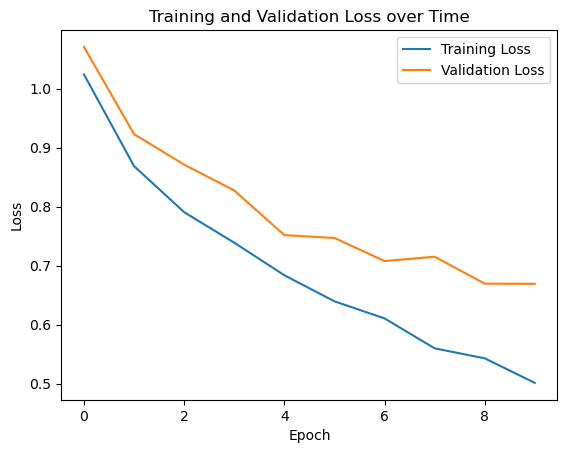

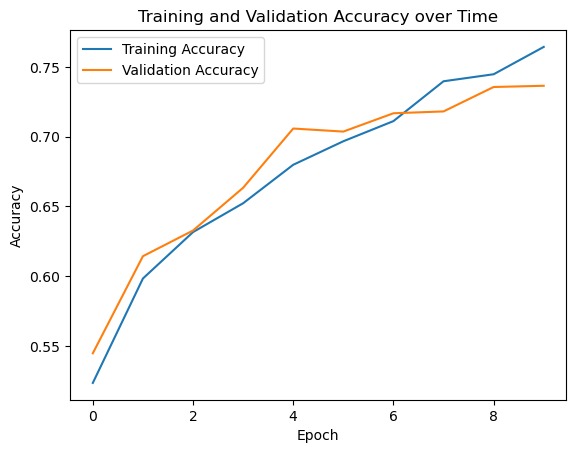

72/72 [==============================] - 5s 59ms/step


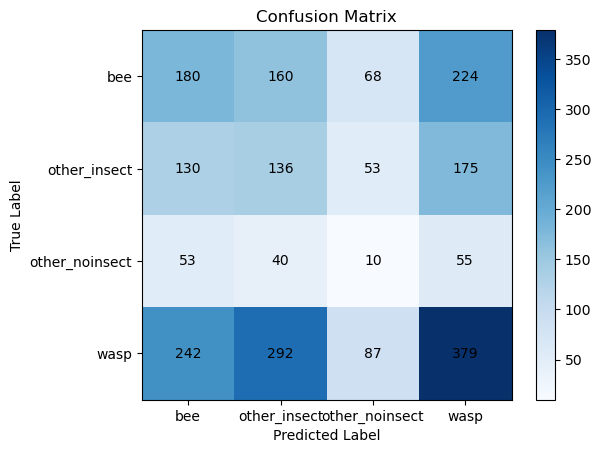

In [16]:
helpers_01.evaluate_model(X_train, X_valid, model, history)

In [ ]:
Some improvement, but not a silver bullet!

## 7. Data Augmentation



In [65]:

def make_model(activation='relu', shape=(80,80,3), num_classes=4):
    '''Sets up a model. 
          Takes in an activation function, shape for the input images, and number of classes.
          Returns the model.'''
    print("***********************************************************************")
    print("Make model:")
    print(f"  - Using the activation function: {activation}.")
    print(f"  - Model will have {num_classes} classes.")
    print("***********************************************************************")
    
    
    data_augmentation = tf.keras.Sequential([
                              layers.RandomFlip("horizontal_and_vertical"),
                              layers.RandomRotation(0.2),
                              layers.RandomBrightness(factor=0.2),
        
                              ])
    # Define the model
    model = tf.keras.Sequential([
        data_augmentation,
        layers.Conv2D(32, (3, 3), padding='same', activation=activation, input_shape=shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), padding='same', activation=activation),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),
        layers.Conv2D(128, (3, 3), padding='same', activation=activation),
        layers.MaxPooling2D((2, 2), padding='same'),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(128, activation=activation),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

model = make_model()




***********************************************************************
Make model:
  - Using the activation function: relu.
  - Model will have 4 classes.
***********************************************************************


In [70]:
model, history = compile_train_model(X_train, X_valid, model, log_name='augmentation')

***********************************************************************
Compile and Train the model:
  - Using the loss function: <keras.src.losses.SparseCategoricalCrossentropy object at 0x14874b7047d0>.
  - Using the optimizer: Adam.
  - Using learning rate of: 0.0001.
  - Running for 10 epochs.
   -Using class weights: {0: 1, 1: 1, 2: 1, 3: 1})
***********************************************************************
Epoch 1/10
286/286 [==============================] - 67s 229ms/step - loss: 0.7976 - accuracy: 0.6779 - val_loss: 0.8061 - val_accuracy: 0.6848
Epoch 2/10
286/286 [==============================] - 66s 229ms/step - loss: 0.7675 - accuracy: 0.6887 - val_loss: 0.7956 - val_accuracy: 0.6865
Epoch 3/10
286/286 [==============================] - 64s 223ms/step - loss: 0.7458 - accuracy: 0.7040 - val_loss: 0.8279 - val_accuracy: 0.6686
Epoch 4/10
286/286 [==============================] - 65s 225ms/step - loss: 0.7339 - accuracy: 0.7019 - val_loss: 0.7887 - val_accuracy: 0.687

***********************************************************************
Evaluate the model:
***********************************************************************
72/72 [==============================] - 4s 58ms/step - loss: 0.7806 - accuracy: 0.7058
Test loss: 0.7805654406547546
Test accuracy: 0.7057793140411377


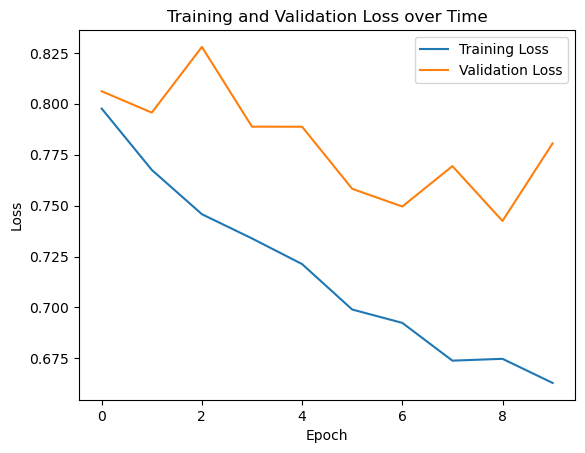

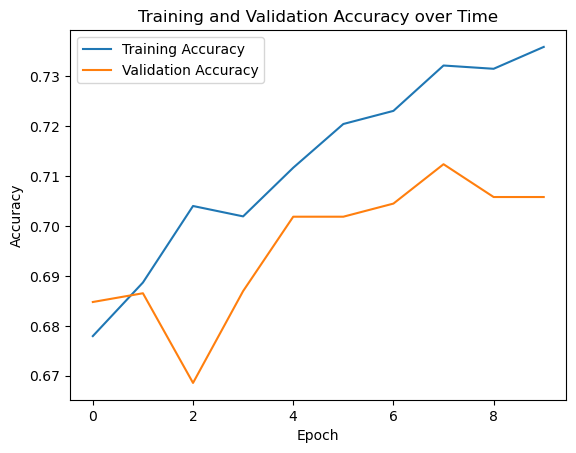

72/72 [==============================] - 4s 58ms/step


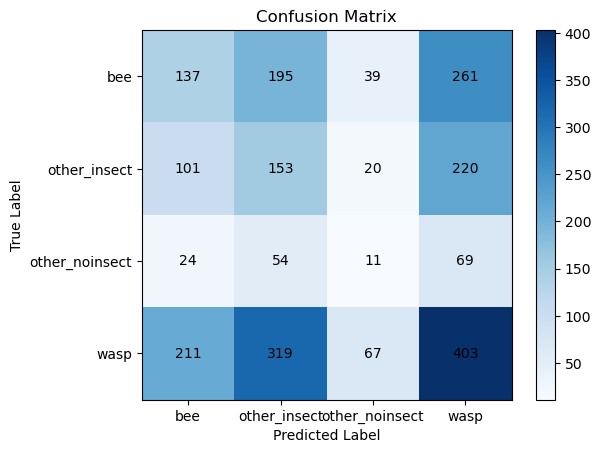

In [71]:
helpers_01.evaluate_model(X_train, X_valid, model, history)

Some improvement, but not a silver bullet!

## 7. Over and Undersampling

Another option outlined in the Thakur & Gosthipaty article is to over or undersample the data. In oversampling, we keep the same number of the majority class, wasps in our case, and resample the other classes duplicating images to reach the same number. Importantly, as noted but Thakur & Gosthipaty:

> With this technique, it is essential to note that we are artificially reducing the dataset's variance. The resulting model might do poorly upon data shift or data corruption.

Alternatively, with undersampling, we limit the number of images per class to the number in the class with the fewest images, other non-insects in our case. 

Below is the relevant code of our existing data loader in the [helpers_01.py](helpers_01.py) file:

'''python
 # Load the dataset
    X_train = tf.keras.preprocessing.image_dataset_from_directory(
        directory_path,
        batch_size=batch_size,
        image_size=image_size,
        validation_split=0.2,
        subset='training',
        seed=123,
        labels='inferred',
        label_mode='int'
    )
    
    X_test = tf.keras.preprocessing.image_dataset_from_directory(
        directory_path,
        batch_size=batch_size,
        image_size=image_size,
        validation_split=0.2,
        subset='validation',
        seed=123,
        labels='inferred',
        label_mode='int'
    )
'''

To change this, we will use the `tf.Data.sample_from_datasets function` (note that the `tf.experimental.sample_from_datasets` function suggested by Thakur & Gosthipaty is depricated).

sample_from_datasets(
    datasets,
    weights=None,
    seed=None,
    stop_on_empty_dataset=False,
    rerandomize_each_iteration=None
)

In [53]:
# Check our data path
print(f'Data are at: {data_path}, with folders named {sorted(os.listdir(data_path))}')

datasets=[]
for folder in sorted(os.listdir(data_path)):
    datasets.append(os.path.join(data_path, folder))
   
print(f'The datasets list is now: {datasets}')

# Set batch size and image size
batch_size=32
image_size=[80,80]

# Create X_train and X_test for each catergory
X_train={}
X_valid={}

folder_count=0 # set for labels
for folder in sorted(os.listdir(data_path)):
    
    # Get the list of images in the class
    images = os.listdir(os.path.join(data_path, folder))
    # Append the number of images in the class to the list
    num_images=(len(images))
    
    labels=[folder_count] * num_images
    
    X_train[folder_count] = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(data_path, folder),
        batch_size=batch_size,
        image_size=image_size,
        validation_split=0.2,
        subset='training',
        seed=123,
        labels=labels,
        label_mode='int'
    )
    
    X_valid[folder_count] = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(data_path, folder),
        batch_size=batch_size,
        image_size=image_size,
        validation_split=0.2,
        subset='validation',
        seed=123,
        labels=labels,
        label_mode='int'
    )
    
    # We don't need to resample the validation dataset
    # So, concatinate them as we go after the 1st one
    if folder_count == 1:
        X_valid_combined = X_valid[0].concatenate(X_valid[1])
    elif folder_count > 1:
        X_valid_combined = X_valid_combined.concatenate(X_valid[folder_count])
        
    folder_count+=1



# Make the resampled dataset
X_train_resampled = tf.data.Dataset.sample_from_datasets(list(X_train.values()),
                stop_on_empty_dataset=True,
                rerandomize_each_iteration=True
)





Data are at: /blue/practicum-ai/share/data/bee_vs_wasp, with folders named ['bee', 'other_insect', 'other_noinsect', 'wasp']
The datasets list is now: ['/blue/practicum-ai/share/data/bee_vs_wasp/bee', '/blue/practicum-ai/share/data/bee_vs_wasp/other_insect', '/blue/practicum-ai/share/data/bee_vs_wasp/other_noinsect', '/blue/practicum-ai/share/data/bee_vs_wasp/wasp']
Found 3184 files belonging to 1 classes.
Using 2548 files for training.
Found 3184 files belonging to 1 classes.
Using 636 files for validation.
Found 2439 files belonging to 1 classes.
Using 1952 files for training.
Found 2439 files belonging to 1 classes.
Using 487 files for validation.
Found 856 files belonging to 1 classes.
Using 685 files for training.
Found 856 files belonging to 1 classes.
Using 171 files for validation.
Found 4943 files belonging to 1 classes.
Using 3955 files for training.
Found 4943 files belonging to 1 classes.
Using 988 files for validation.


In [54]:
model, history = compile_train_model(X_train_resampled, X_valid_combined, model,  cls_counts=cls_counts, log_name='oversample')

AttributeError: '_DirectedInterleaveDataset' object has no attribute 'class_names'

In [57]:
 model.compile(optimizer='Adam',
                  loss=SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])
epochs = 10
learning_rate = 0.001
log_name = 'oversample'

time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

log_dir = f"logs/fit_weights_{log_name}_{epochs}_{time}"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


# Train the model
history = model.fit(X_train_resampled, epochs=epochs, steps_per_epoch=286, validation_data=X_valid_combined, callbacks=[tensorboard_callback])

Epoch 1/10
286/286 [==============================] - 25s 84ms/step - loss: 1.3898 - accuracy: 0.2217 - val_loss: 1.3936 - val_accuracy: 0.0749
